In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import os
from glob import glob

In [332]:
path = 'C:/Users/Sarv/Downloads/dashboard/marketwatch_ts/'
path_total = 'C:/Users/Sarv/Downloads/dashboard/marketwatch_mod/'
files_ts = glob(path + '*.csv')

In [351]:
df = pd.read_csv(files_ts[77])
df['namad'][0]

'ثمسكن'

# KPI 1:Rolling_Return 

In [293]:
def rolling_ret_plot(df, jdate):
    df_ix = df.copy().set_index('jdate')
    df_ix['rolling_ret'] = df_ix.close_price.sub(df_ix.close_price.loc[jdate])*(-1)/df_ix.close_price.loc[jdate]
    benchmark_date = df_ix.loc[jdate]['date']
    rolling_ret = df_ix[df_ix['date'] > benchmark_date].sort_values(by='date')['rolling_ret']
    return rolling_ret.plot(figsize=(20,8))

<AxesSubplot:xlabel='jdate'>

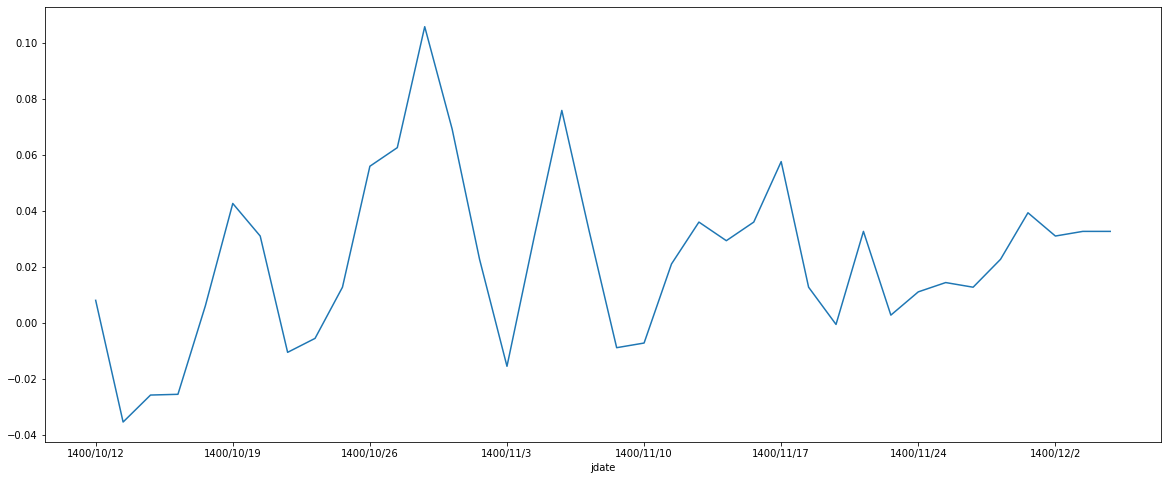

In [305]:
rolling_ret_plot(df, '1400/10/11')

# KPI 2: Kernel Density Estimation plot

<AxesSubplot:ylabel='Density'>

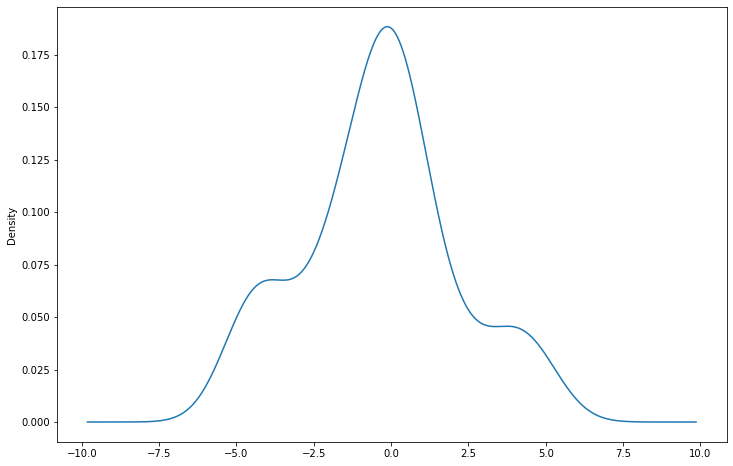

In [329]:
df['close_perc'].plot.kde(figsize=(12,8))

# KPI 3: Moving Average

In [ ]:
def moving_average_plot(df, jdate):
    df_ix = df.copy().set_index('jdate')
    df_ix['MA'] = df_ix.close_perc.rolling(window=5).mean()
    benchmark_date = df_ix.loc[jdate]['date']
    MA_period = df_ix[df_ix['date'] > benchmark_date].sort_values(by='date')['MA']
    ret_period = df_ix[df_ix['date'] > benchmark_date].sort_values(by='date')['close_perc']
    return ret_period.plot(figsize=(20,8)) , MA_period.plot(figsize=(20,8))

(<AxesSubplot:xlabel='jdate'>, <AxesSubplot:xlabel='jdate'>)

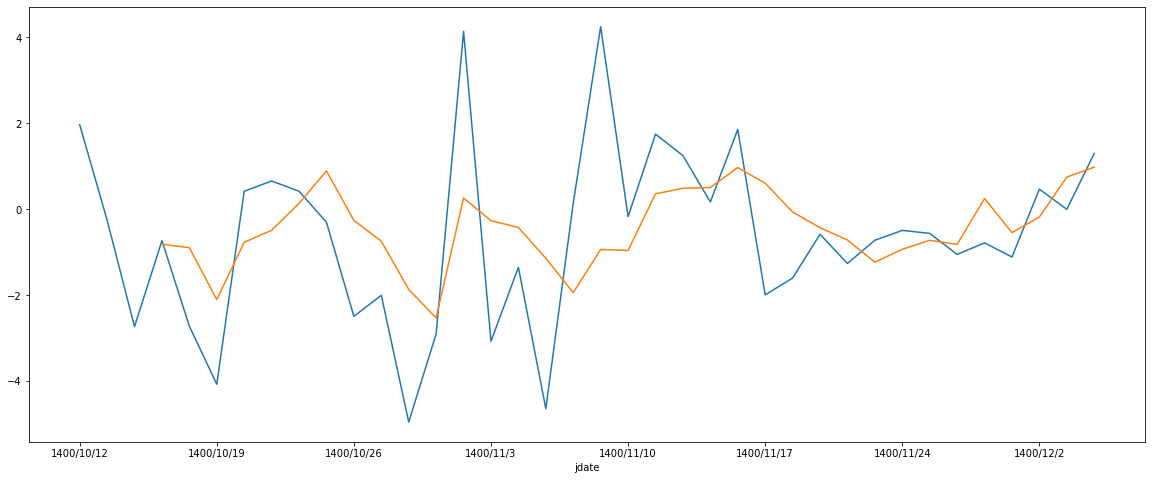

In [358]:
moving_average_plot(df, '1400/10/11')

# correlation_heatmap

In [442]:
df_ret = pd.DataFrame()
for file in files_ts:
    filename =file.split('\\')[1].split('.')[0] 
    df = pd.read_csv(file)
    df_ret[f'{filename}'] = df['close_perc']
df_ret[['jdate', 'date']] = df[['jdate', 'date']]
cov_matrix = df_ret.cov()
corr_matrix = df_ret.corr()

In [438]:
def corr_heatmap(namad, num):
    nlargest = set(corr_matrix[namad].nlargest(num).index)
    nsmallest = set(corr_matrix[namad].nsmallest(num).index)
    union = set.union(nlargest, nsmallest)
    fig, ax = plt.subplots(figsize=(11,8))
    heatmap_matrix = df_ret[union].corr()
    return sns.heatmap(heatmap_matrix)

<AxesSubplot:>

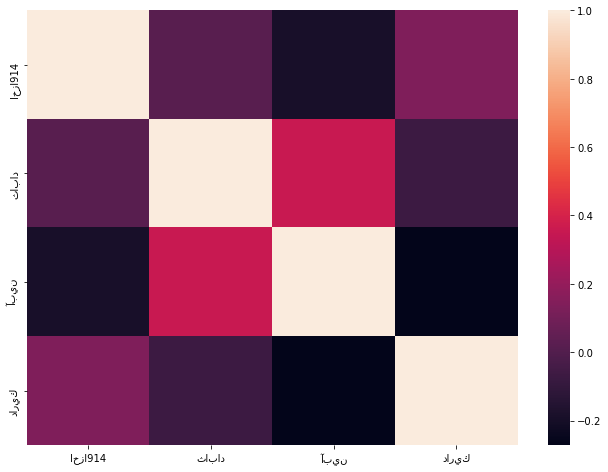

In [439]:
corr_heatmap(df_ret.columns[0],2)

# Portfolio VaR
source: https://www.interviewqs.com/blog/value-at-risk

In [462]:
namads = [df_ret.columns[0], df_ret.columns[45], df_ret.columns[20], df_ret.columns[11]]
weights = np.array([.25, .3, .15, .3])
initial_inv = 1000000000
avg_rets = df_ret[namads].mean()
port_mean = avg_rets.dot(weights)
mean_investment = (1+port_mean) * initial_inv
cov_matrix2 = df_ret[namads].cov()
port_stdev = np.sqrt(weights.T.dot(cov_matrix2).dot(weights))
stdev_investment = initial_inv * port_stdev
conf_level1 = 0.05
from scipy.stats import norm
cutoff1 = norm.ppf(conf_level1, mean_investment, stdev_investment)
var_1d1 = initial_inv - cutoff1
var_1d1

2888404077.9371343

1 day VaR @ 95% confidence: 2888404077.94
2 day VaR @ 95% confidence: 4084820220.63
3 day VaR @ 95% confidence: 5002862615.78
4 day VaR @ 95% confidence: 5776808155.87
5 day VaR @ 95% confidence: 6458667864.76
6 day VaR @ 95% confidence: 7075116161.92
7 day VaR @ 95% confidence: 7641998876.09
8 day VaR @ 95% confidence: 8169640441.26
9 day VaR @ 95% confidence: 8665212233.81
10 day VaR @ 95% confidence: 9133935689.2
11 day VaR @ 95% confidence: 9579752569.45
12 day VaR @ 95% confidence: 10005725231.55
13 day VaR @ 95% confidence: 10414289007.26
14 day VaR @ 95% confidence: 10807418454.2
15 day VaR @ 95% confidence: 11186740890.97


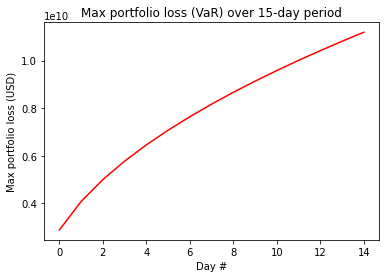

In [479]:
# Calculate n Day VaR
var_array = []
num_days = int(15)
for x in range(1, num_days+1):    
    var_array.append(np.round(var_1d1 * np.sqrt(x),2))
    print(str(x) + " day VaR @ 95% confidence: " + str(np.round(var_1d1 * np.sqrt(x),2)))

# Build plot
plt.xlabel("Day #")
plt.ylabel("Max portfolio loss (USD)")
plt.title("Max portfolio loss (VaR) over 15-day period")
plt.plot(var_array, "r")